<a href="https://colab.research.google.com/github/takman99/Stock-Market-Prediction-Using-LSTM-and-GRU-Neural-Networks/blob/main/LSTM_Multi_Layer.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# LSTM Model



In [ ]:
# Importing libraries
!pip install yfinance --upgrade --no-cache-dir
!pip install --upgrade pandas
!pip install pycryptodome pycryptodomex
!pip uninstall --yes pandas-datareader
!pip install git+https://github.com/raphi6/pandas-datareader.git@ea66d6b981554f9d0262038aef2106dda7138316
!pip install scikit-optimize
import math
import yfinance as yf
import numpy as np
import pandas as pd
import pandas_datareader as web
import tensorflow as tf
from tensorflow.keras.regularizers import L1, L2, L1L2
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_absolute_error
from keras.models import Sequential
from keras.layers import Dense, LSTM, Dropout
from keras.optimizers import Adam, RMSprop, Adagrad, Nadam
from keras.activations import relu, tanh, linear
from keras.callbacks import EarlyStopping
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_absolute_error
from sklearn.model_selection import train_test_split
from skopt import gp_minimize
from skopt.space import Real, Integer, Categorical
from skopt.utils import use_named_args
import matplotlib.pyplot as plt
plt.style.use('fivethirtyeight')

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 63.0/63.0 kB 1.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 62.6/62.6 kB 10.0 MB/s eta 0:00:00
  Attempting uninstall: requests
    Found existing installation: requests 2.27.1
    Uninstalling requests-2.27.1:
      Successfully uninstalled requests-2.27.1
  Attempting uninstall: yfinance
    Found existing installation: yfinance 0.2.25
    Uninstalling yfinance-0.2.25:
      Successfully uninstalled yfinance-0.2.25
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
google-colab 1.0.0 requires requests==2.27.1, but you have requests 2.31.0 which is incompatible.
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 12.3/12.3 MB 68.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 341.8/341.8 kB 37.5 MB/s eta 0:00:00
  Attempting uninstall: pandas
    Found existing installation: pandas 1.5.3
 

In [ ]:
np.random.seed(42)
tf.random.set_seed(42)

In [ ]:
df = yf.download("^GSPC", start="2000-01-03", end="2016-11-10")

# Selecting the 6 input features
data = df[['Open', 'High', 'Low', 'Close', 'Adj Close', 'Volume']]
dataset = data.values

training_data_len = len(dataset) - 400

# Fitting the MinMaxScaler only on the training data
scaler = MinMaxScaler(feature_range=(0, 1))
scaler.fit(dataset[:training_data_len])

# Transforming both the training and test data using the fitted scaler
scaled_data = scaler.transform(dataset)

train_data = scaled_data[0:training_data_len, :]
x_train = []
y_train = []

for i in range(60, len(train_data)):
    x_train.append(train_data[i - 60:i, :])
    y_train.append(train_data[i, 3])  # Use the 'Close' price as the target

x_train, y_train = np.array(x_train), np.array(y_train)
x_train = np.reshape(x_train, (x_train.shape[0], x_train.shape[1], 6))

#Test data
test_data = scaled_data[training_data_len - 60:, :]
x_test = []
y_test = dataset[training_data_len:, 3]  # 'Close' price

for i in range(60, len(test_data)):
    x_test.append(test_data[i - 60:i, :])

x_test = np.array(x_test)
x_test = np.reshape(x_test, (x_test.shape[0], x_test.shape[1], 6))

[*********************100%***********************]  1 of 1 completed


In [ ]:
# Determining the index where the validation set should start
validation_start_index = int(x_train.shape[0] * 0.8)

# Spliing the training data into training and validation sets
x_train, x_val = x_train[:validation_start_index], x_train[validation_start_index:]
y_train, y_val = y_train[:validation_start_index], y_train[validation_start_index:]


def lstm_model_optimize(params):
    learning_rate, epochs, batch_size, dropout, activation_function, optimizer, neurons_1, neurons_2,neurons_3, neurons_4, l2_lambda = params

    model = Sequential()
    model.add(LSTM(neurons_1, return_sequences=True, input_shape=(x_train.shape[1], 6), activation=activation_function, kernel_regularizer=L2(l2_lambda)))
    model.add(Dropout(dropout))
    model.add(LSTM(neurons_2, return_sequences=False, activation=activation_function, kernel_regularizer=L2(l2_lambda)))
    model.add(Dropout(dropout))
    model.add(Dense(neurons_3, activation=activation_function))
    model.add(Dense(neurons_4))

    opt = optimizer(learning_rate=learning_rate)
    model.compile(optimizer=opt, loss='mean_squared_error')
    model.fit(x_train, y_train, batch_size=batch_size, epochs=epochs, verbose=1, validation_data=(x_val, y_val), callbacks=[early_stopping])


    predictions = model.predict(x_val)
    predicted_data = np.zeros((predictions.shape[0], dataset.shape[1]))
    predicted_data[:, 3] = predictions[:, 0]
    predictions = scaler.inverse_transform(predicted_data)[:, 3]


    # Inverse transform y_val
    y_val_unscaled_data = np.zeros((y_val.shape[0], dataset.shape[1]))
    y_val_unscaled_data[:, 3] = y_val
    y_val_unscaled = scaler.inverse_transform(y_val_unscaled_data)[:, 3]

    mse = np.mean(((predictions - y_val_unscaled) ** 2))

    rmse = np.sqrt(np.mean(((predictions - y_val_unscaled) ** 2)))
    print('rmse=', rmse)
    #Checking if MSE is "nan" and returning a large value if it is
    if np.isnan(mse):
        return 1e6
    else:
      return mse


# Search space for hyperparameters
space = [
    Categorical([0.0001, 0.001, 0.01, 0.1], name="learning_rate"),
    Categorical([100, 200, 300, 400, 500,1000], name="epochs"),
    Categorical([8, 16, 32, 64], name="batch_size"),
    Categorical([0.1, 0.2, 0.3, 0.4, 0.5], name="dropout"),
    Categorical(['tanh', 'sigmoid','relu'], name="activation_function"),
    Categorical([Adam, RMSprop, Adagrad], name="optimizer"),
    Categorical([60, 80, 100, 120, 140, 160, 180], name="neurons_1"),
    Categorical([60, 80, 100, 120, 140, 160, 180], name="neurons_2"),
    Integer(15, 30, name="neurons_3"),
    Integer(1, 10, name="neurons_4"),
    Categorical([0.0005, 0.0001, 0.00005, 0.00001], name="l2_lambda"),
]


early_stopping = EarlyStopping(monitor='val_loss', patience=8, restore_best_weights=True)
# Bayesian optimization using gp_minimize
result = gp_minimize(lstm_model_optimize, space, n_calls=20, n_random_starts=10, verbose=1, n_jobs=-1)

# Extracting the optimal hyperparameters
opt_learning_rate, opt_epochs, opt_batch_size, opt_dropout, opt_activation_function, opt_optimizer, opt_neurons_1, opt_neurons_2, opt_neurons_3, opt_neurons_4, opt_l2_lambda = result.x

# Training the LSTM model with the optimal hyperparameters
model = Sequential()
model.add(LSTM(opt_neurons_1, return_sequences=True, input_shape=(x_train.shape[1], 6), activation=opt_activation_function, kernel_regularizer=L2(opt_l2_lambda)))
model.add(Dropout(opt_dropout))
model.add(LSTM(opt_neurons_2, return_sequences=False, activation=opt_activation_function, kernel_regularizer=L2(opt_l2_lambda)))
model.add(Dropout(opt_dropout))
model.add(Dense(opt_neurons_3, activation=opt_activation_function))
model.add(Dense(opt_neurons_4))

opt = opt_optimizer(learning_rate=opt_learning_rate)
model.compile(optimizer=opt, loss='mean_squared_error')
model.fit(x_train, y_train, batch_size=opt_batch_size, epochs=opt_epochs, verbose=1, callbacks=[early_stopping])

predictions = model.predict(x_test)
predicted_data = np.zeros((predictions.shape[0], dataset.shape[1]))
predicted_data[:, 3] = predictions[:, 0]
predictions = scaler.inverse_transform(predicted_data)[:, 3]


# Calculation for Root Mean Square Error (RMSE)
rmse = np.sqrt(np.mean(((predictions - y_test) ** 2)))
print('rmse= ' + str(rmse))

# Calculation for Mean Absolute Error (MAE)
mae = mean_absolute_error(predictions, y_test)
print('mae= ' + str(mae))


# Calculation for Mean Absolute Percentage Error (MAPE)
mape = np.mean(np.abs((predictions - y_test) / y_test)) * 100
print('mape= ' + str(mape))

# Calculation for Adjusted Mean Absolute Percentage Error (AMAPE)
amape = np.mean(np.abs((predictions - y_test) / np.mean(y_test))) * 100
print('amape= ' + str(amape))


print("Optimal learning rate:", opt_learning_rate)
print("Optimal epochs:", opt_epochs)
print("Optimal batch size:", opt_batch_size)
print("Optimal dropout rate:", opt_dropout)
print("Optimal activation function:", opt_activation_function)
print("Optimal optimizer:", opt_optimizer.__name__)
print("Optimal neurons 1:", opt_neurons_1)
print("Optimal neurons 2:", opt_neurons_2)
print("Optimal Dense neuron 1:", opt_neurons_3)
print("Optimal Dense neuron 2:", opt_neurons_4)
print("L2 regularization lambda:", opt_l2_lambda)


Iteration No: 1 started. Evaluating function at random point.


Epoch 1/200
95/95 [==============================] - 21s 149ms/step - loss: 0.0316 - val_loss: 0.1614
Epoch 2/200
95/95 [==============================] - 14s 145ms/step - loss: 0.0182 - val_loss: 0.1639
Epoch 3/200
95/95 [==============================] - 14s 145ms/step - loss: 0.0171 - val_loss: 0.1402
Epoch 4/200
95/95 [==============================] - 14s 144ms/step - loss: 0.0168 - val_loss: 0.1663
Epoch 5/200
95/95 [==============================] - 14s 144ms/step - loss: 0.0168 - val_loss: 0.1712
Epoch 6/200
95/95 [==============================] - 13s 142ms/step - loss: 0.0165 - val_loss: 0.1498
Epoch 7/200
95/95 [==============================] - 14s 143ms/step - loss: 0.0167 - val_loss: 0.1524
Epoch 8/200
95/95 [==============================] - 14s 147ms/step - loss: 0.0163 - val_loss: 0.1733
Epoch 9/200
95/95 [==============================] - 14s 144ms/step - loss: 0.0165 - val_loss: 0.1708
Epoch 10/200
95/95 [==============================] - 14s 144ms/step - loss: 0.016

rmse= 540.0161554565261
Iteration No: 1 ended. Evaluation done at random point.
Time taken: 163.0026
Function value obtained: 291617.4482
Current minimum: 291617.4482
Iteration No: 2 started. Evaluating function at random point.


Epoch 1/1000
379/379 [==============================] - 59s 149ms/step - loss: 0.0185 - val_loss: 0.0862
Epoch 2/1000
379/379 [==============================] - 55s 145ms/step - loss: 0.0053 - val_loss: 0.0541
Epoch 3/1000
379/379 [==============================] - 55s 145ms/step - loss: 0.0040 - val_loss: 0.0780
Epoch 4/1000
379/379 [==============================] - 55s 145ms/step - loss: 0.0034 - val_loss: 0.0812
Epoch 5/1000
379/379 [==============================] - 54s 143ms/step - loss: 0.0030 - val_loss: 0.0450
Epoch 6/1000
379/379 [==============================] - 55s 145ms/step - loss: 0.0028 - val_loss: 0.0478
Epoch 7/1000
379/379 [==============================] - 55s 144ms/step - loss: 0.0026 - val_loss: 0.0553
Epoch 8/1000
379/379 [==============================] - 54s 143ms/step - loss: 0.0024 - val_loss: 0.0632
Epoch 9/1000
379/379 [==============================] - 55s 145ms/step - loss: 0.0023 - val_loss: 0.0580
Epoch 10/1000
379/379 [==============================] 

rmse= 303.7825076423497
Iteration No: 2 ended. Evaluation done at random point.
Time taken: 717.3064
Function value obtained: 92283.8119
Current minimum: 92283.8119
Iteration No: 3 started. Evaluating function at random point.


Epoch 1/200
379/379 [==============================] - 57s 146ms/step - loss: 0.0274 - val_loss: 0.2808
Epoch 2/200
379/379 [==============================] - 55s 146ms/step - loss: 0.0214 - val_loss: 0.1008
Epoch 3/200
379/379 [==============================] - 55s 146ms/step - loss: 0.0202 - val_loss: 0.1738
Epoch 4/200
379/379 [==============================] - 55s 145ms/step - loss: 0.0197 - val_loss: 0.1290
Epoch 5/200
379/379 [==============================] - 55s 145ms/step - loss: 0.0194 - val_loss: 0.1106
Epoch 6/200
379/379 [==============================] - 55s 146ms/step - loss: 0.0192 - val_loss: 0.1475
Epoch 7/200
379/379 [==============================] - 55s 146ms/step - loss: 0.0191 - val_loss: 0.1183
Epoch 8/200
379/379 [==============================] - 56s 147ms/step - loss: 0.0189 - val_loss: 0.2038
Epoch 9/200
379/379 [==============================] - 55s 146ms/step - loss: 0.0187 - val_loss: 0.1677
Epoch 10/200
24/24 [==============================] - 1s 15ms/st

rmse= 473.15045690226356
Iteration No: 3 ended. Evaluation done at random point.
Time taken: 555.8562
Function value obtained: 223871.3549
Current minimum: 92283.8119
Iteration No: 4 started. Evaluating function at random point.


Epoch 1/400
190/190 [==============================] - 31s 149ms/step - loss: nan - val_loss: nan
Epoch 2/400
 31/190 [===>..........................] - ETA: 23s - loss: nan

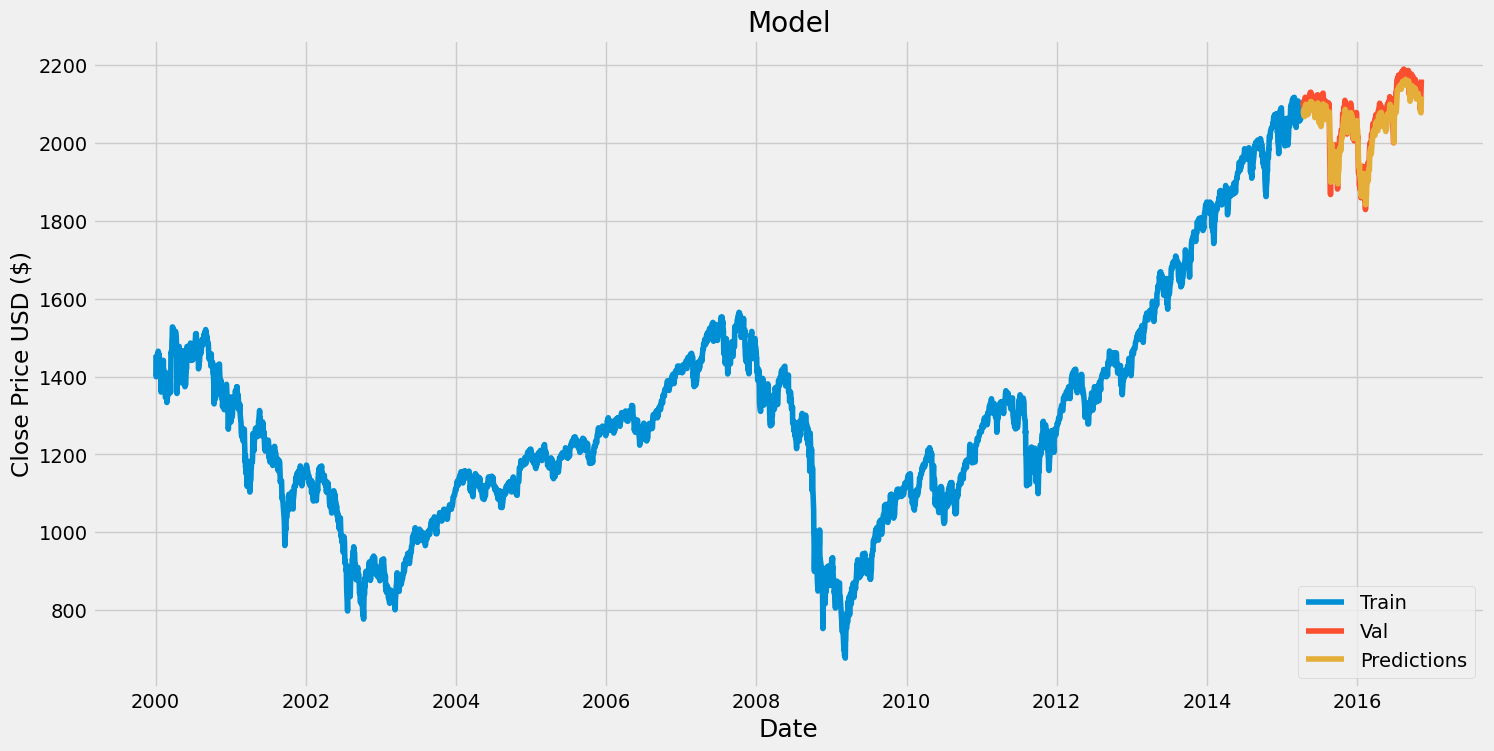

In [ ]:
#Plotting the data
train = data[:training_data_len]
valid = data[training_data_len:].copy()
valid.loc[:,'Predictions'] = predictions
#Visualising the model
plt.figure(figsize=(16,8))
plt.title('Model')
plt.xlabel('Date', fontsize=18)
plt.ylabel('Close Price USD ($)')
plt.plot(train['Adj Close'])
plt.plot(valid[['Adj Close', 'Predictions']])
plt.legend(['Train', 'Val', 'Predictions'], loc='lower right')
plt.show()

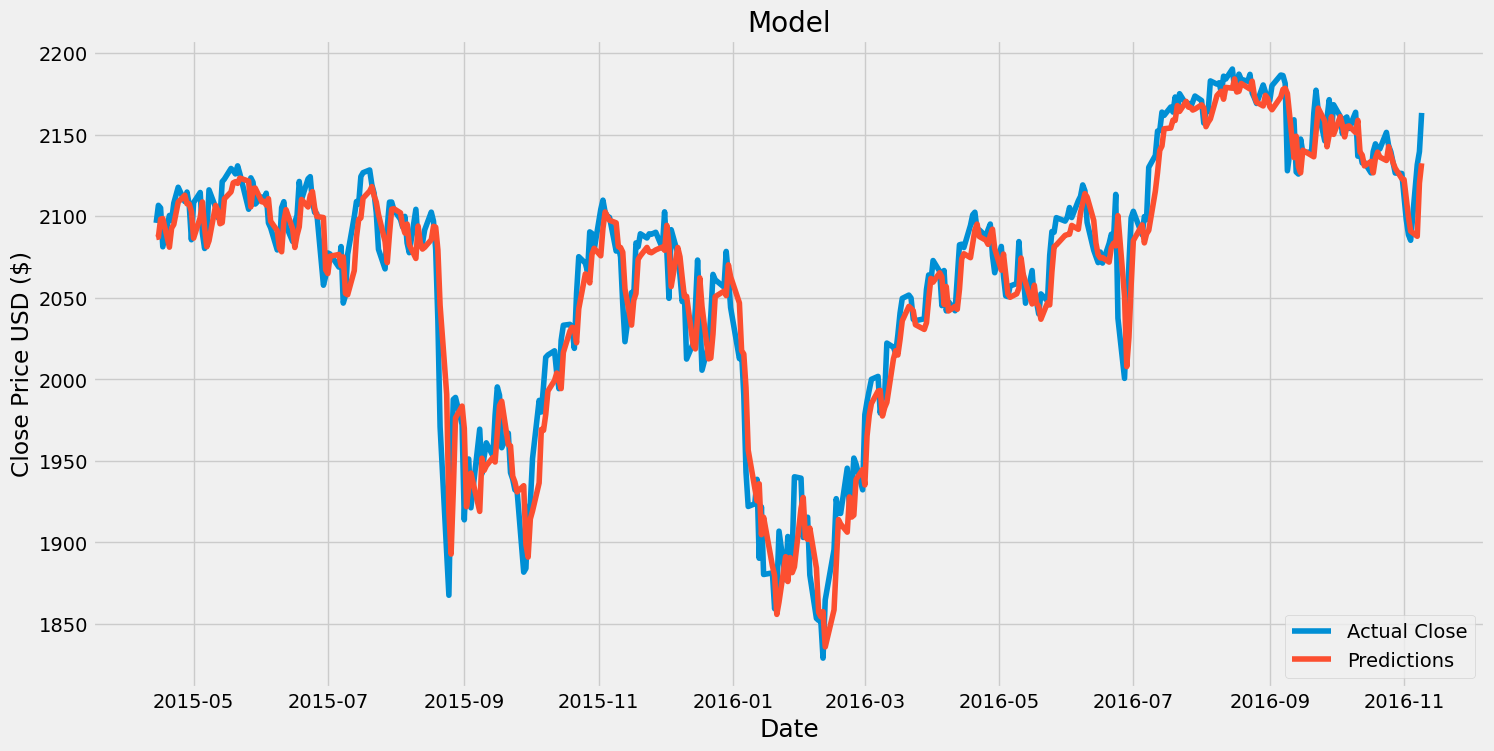

In [ ]:
#Plotting the data
valid = data[training_data_len:].copy()
valid.loc[:,'Predictions'] = predictions

#Visualising the model
plt.figure(figsize=(16,8))
plt.title('Model')
plt.xlabel('Date', fontsize=18)
plt.ylabel('Close Price USD ($)')
plt.plot(valid[['Adj Close', 'Predictions']])
plt.legend(['Actual Close', 'Predictions'], loc='lower right')
plt.show()

In [ ]:
#Download the Model Results
import pickle

variables = {
    'data': data,
    'training_data_len': training_data_len,
    'scaler': scaler,
    'x_train': x_train,
    'y_train': y_train,
    'x_test': x_test,
    'y_test': y_test,
    'predictions': predictions,
    'rmse': rmse,
    'mae': mae,
    'mape': mape,
    'amape': amape,
    'opt_learning_rate': opt_learning_rate,
    'opt_epochs': opt_epochs,
    'opt_batch_size': opt_batch_size,
    'opt_dropout': opt_dropout,
    'opt_activation_function': opt_activation_function,
    'opt_optimizer': opt_optimizer.__name__,
    'opt_neurons_1': opt_neurons_1,
    'opt_neurons_2': opt_neurons_2,
    'opt_neurons_3': opt_neurons_3,
    'opt_neurons_4': opt_neurons_4,
    'opt_l2_lambda': opt_l2_lambda

}

with open('lstm_multi.pickle', 'wb') as f:
    pickle.dump(variables, f)
